In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import missingno as msno
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [2]:
# Columns needed to be parsed as datetime
dates = [
            
            "started_at",
            "ended_at",
            "end_date"
]

# Drop columns
cols_to_drop = ["Year","start_time","end_time","start_date"]

# Read csv
df = pd.read_csv("bicycle_sharing_cleaned.csv",parse_dates=dates).drop(cols_to_drop,axis=1)


In [3]:
df.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,end_date,start_month,end_month
0,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,Lincoln Ave & Diversey Pkwy,member,2020-04-26,April,April
1,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,Kosciuszko Park,member,2020-04-17,April,April
2,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,Indiana Ave & Roosevelt Rd,member,2020-04-01,April,April
3,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,Wood St & Augusta Blvd,member,2020-04-07,April,April
4,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,Sheridan Rd & Lawrence Ave,casual,2020-04-18,April,April


In [4]:
# Convert columns to category for lower memory usage
df[["rideable_type","member_casual"]] = df[["rideable_type","member_casual"]].astype("category")

In [5]:
df.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,end_date,start_month,end_month
0,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,Lincoln Ave & Diversey Pkwy,member,2020-04-26,April,April
1,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,Kosciuszko Park,member,2020-04-17,April,April
2,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,Indiana Ave & Roosevelt Rd,member,2020-04-01,April,April
3,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,Wood St & Augusta Blvd,member,2020-04-07,April,April
4,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,Sheridan Rd & Lawrence Ave,casual,2020-04-18,April,April


In [6]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14758113 entries, 0 to 14758112
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rideable_type       category      
 1   started_at          datetime64[ns]
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   end_station_name    object        
 5   member_casual       category      
 6   end_date            datetime64[ns]
 7   start_month         object        
 8   end_month           object        
dtypes: category(2), datetime64[ns](3), object(4)
memory usage: 4.1 GB


In [7]:
# Calculate the length of each ride by time
df["ride_length"] = df["ended_at"] - df["started_at"]

### Time travel??
`.describe()` function will show the numerical and date time information to include: average, minimum and maximum values and other important information about the data.

It looks like we have time travelers in our dataset. Individuals that started their rides in the future, and ended their rides in the past. This dataset has some interesting datapoints in the "ride_length" column with negative days.

I don't really know why this is the case, and I thought I had corrected this earlier in the data cleaning phase, but it's still apparent. I'm confident that removing any rows with less than 0 minute ride times should fix this. I want the data to be as accurate as possible and these extreme datapoints are interfering with that goal.

In [8]:
df["ride_length"].describe()

count                     14758113
mean     0 days 00:21:51.024610937
std      0 days 03:39:47.923015718
min             -21 days +19:50:02
25%                0 days 00:06:29
50%                0 days 00:11:39
75%                0 days 00:21:24
max               40 days 18:40:02
Name: ride_length, dtype: object

In [9]:
#?????
df[df["ride_length"] <= "-21 days +20:05:17"]

,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,end_date,start_month,end_month,ride_length
3009987,electric_bike,2020-12-15 11:35:39,2020-11-25 07:40:56,Sheffield Ave & Willow St,Sheffield Ave & Willow St,member,2020-11-25,December,November,-21 days +20:05:17
3044291,electric_bike,2020-12-15 12:10:14,2020-11-25 08:00:16,Wells St & Concord Ln,Clark St & Schiller St,member,2020-11-25,December,November,-21 days +19:50:02


In [10]:
# This will remove any incorrect data by re-assigning the dataframe that exludes anything less than 0 minutes
df = df[df["ride_length"] >= "00:00:00"]

In [11]:
df["ride_length"].describe()

count                     14747526
mean     0 days 00:22:11.721441955
std      0 days 03:17:23.954350290
min                0 days 00:00:00
25%                0 days 00:06:29
50%                0 days 00:11:40
75%                0 days 00:21:24
max               40 days 18:40:02
Name: ride_length, dtype: object

## Number of rides per month
I'm interested to see the pattern that Cyclistic has when it comes to renting bikes throughout the year.

- Bike sharing increases from May to October and peaks in the summer(July and August).
- Bike sharing is lowest in the spring and winter

In [12]:
# Count the number of rides per month
month_series = df["start_month"].value_counts()

<AxesSubplot:>

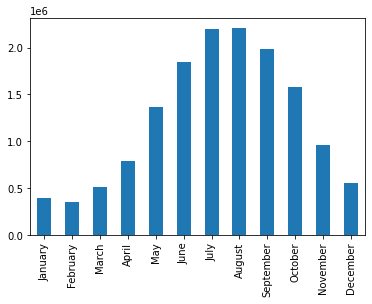

In [13]:
# Displays the number of rides per month
month_series.iloc[[10,11,9,7,5,3,1,0,2,4,6,8]].plot(kind="bar")

In [14]:
members = df[df["member_casual"]== "member"]

In [15]:
casual = df[df["member_casual"]== "casual"]

<AxesSubplot:>

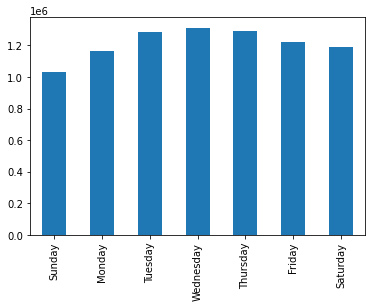

In [16]:
# Number of rides per day for members
members["started_at"].dt.day_name().value_counts().iloc[[6,5,2,0,1,3,4]].plot(kind="bar")

<AxesSubplot:>

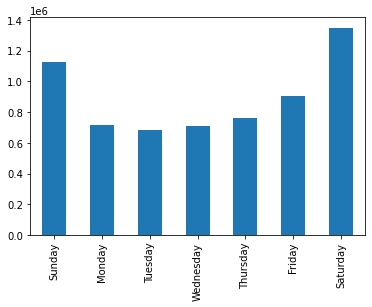

In [17]:
casual["started_at"].dt.day_name().value_counts().iloc[[1,4,6,5,3,2,0]].plot(kind="bar")

In [18]:
print("number of casual riders:",len(casual))
print("number of member riders:",len(members))

number of casual riders: 6248788
number of member riders: 8498738


In [19]:
members["ride_length"].describe()

count                      8498738
mean     0 days 00:13:44.591428868
std      0 days 00:51:32.791233231
min                0 days 00:00:00
25%                0 days 00:05:30
50%                0 days 00:09:34
75%                0 days 00:16:44
max               40 days 18:40:02
Name: ride_length, dtype: object

In [20]:
casual["ride_length"].describe()

count                      6248788
mean     0 days 00:33:41.449612148
std      0 days 04:56:51.029134200
min                0 days 00:00:00
25%                0 days 00:08:39
50%                0 days 00:15:35
75%                0 days 00:29:13
max               38 days 20:24:09
Name: ride_length, dtype: object

In [21]:
df.describe()

,ride_length
count,14747526
mean,0 days 00:22:11.721441955
std,0 days 03:17:23.954350290
min,0 days 00:00:00
25%,0 days 00:06:29
50%,0 days 00:11:40
75%,0 days 00:21:24
max,40 days 18:40:02
